# Импорты

In [4]:
# Импорты
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

# ГИПЕРПАРАМЕТРЫ

In [15]:
# ГИПЕРПАРАМЕТРЫ И КОНСТАНТЫ
RANDOM_SEED = 43  # фиксированное число рандома
SEQ_LENGTH = 3  # длина последовательности
HIDDEN_SIZE = 64 # Размерность вектора каждого входа модели
NUM_LAYERS = 3 # количество слоев нейросети
N_SPLITS = 5  # количество блоков для кросс-валидации
NUM_EPOCHS = 16  # количество эпох обучения 
BATCH_SIZE = 64  # размер батча
LEARNING_RATE = 0.001  # ленинг рейт)

In [17]:
# задаем фиксированные рандомы
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Загрузка данных

В качестве датасета выступает набор данных Московского региона, целевой переменной разница температур фоновых станций и метеостанции Балчуг.
В данном примере тестовой выборкой является июнь 2021 года, а в тренировочной выборкой все остальные данные.
Модель, основанная на рекуррентной нейросети LSTM, попробует аппроксимировать разницу температур на основе крупномасштабных гидрометеорологических параметров.

In [64]:
# Загрузка данных
df = pd.read_csv('D:/RSHU_LIMA_VARENTSOV_2025/data/Moscow_basic.csv', sep=';')
df = df.drop(['time', 'delta_t2m_id27416', 'delta_t2m_id27612', 'delta_t2m_id27617'], axis=1)

columns_to_drop = [col for col in df.columns if col.startswith('rur')]     # оставляем данные реанализа
df = df.drop(columns_to_drop, axis=1)

df = df.dropna()      # удаляем пропуски 

df_test = df.iloc[27511:27752] # июнь 2021 г
#print(df_test)
df_test = df_test.sort_index()  # Убедимся в хронологическом порядке
#print(df_test.head())

df_main = df.drop(df.index[27511:27752]) # остальной набор данных
#print(df_main)
df_main = df_main.sort_index()  # Убедимся в хронологическом порядке
#print(df_main.head())

# Обучаем модель

In [84]:
# Тренировочный/тестовый набор
train_data = df_main.copy()
test_data = df_test.copy()

# Выделение признаков и целевой переменной
features = train_data.columns.drop('delta_t2m_id27605')
target = 'delta_t2m_id27605'

# Создание последовательностей для тренировочных данных
X_train_seq, y_train_seq = [], []

for i in range(SEQ_LENGTH - 1, len(train_data)):
    # Признаки: моменты i-2, i-1, i
    X_train_seq.append(train_data[features].iloc[i-SEQ_LENGTH+1:i+1].values.astype(np.float32))
    # Целевая переменная: момент i
    y_train_seq.append(train_data[target].iloc[i].astype(np.float32))

"""
Подробно разберем пример с разделением на последовательности:
Пусть SEQ_LENGTH = 3 и у нас блок с 10 точками:

Индексы:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Данные:   [A, B, C, D, E, F, G, H, I, J]

Цикл начинается с i = 2 (SEQ_LENGTH - 1):

Итерация 1 (i = 2):
X_block[2-3+1:2+1] = X_block[0:3] = [A, B, C]
y_block[2] = C

Логика: Используем точки [0,1,2] чтобы предсказать точку 2

Итерация 2 (i = 3):
X_block[3-3+1:3+1] = X_block[1:4] = [B, C, D]
y_block[3] = D

Логика: Используем точки [1,2,3] чтобы предсказать точку 3

Итерация 3 (i = 4):
X_block[4-3+1:4+1] = X_block[2:5] = [C, D, E]
y_block[4] = E
И так далее...

Последняя итерация (i = 9):
X_block[9-3+1:9+1] = X_block[7:10] = [H, I, J]
y_block[9] = J
"""
X_train = np.array(X_train_seq)
y_train = np.array(y_train_seq)

# Создание последовательностей для тестовых данных
X_test_seq, y_test_seq = [], []

for i in range(SEQ_LENGTH - 1, len(test_data)):
    # Признаки: моменты i-2, i-1, i
    X_test_seq.append(test_data[features].iloc[i-SEQ_LENGTH+1:i+1].values.astype(np.float32))
    # Целевая переменная: момент i
    y_test_seq.append(test_data[target].iloc[i].astype(np.float32))

X_test = np.array(X_test_seq)
y_test = np.array(y_test_seq)

# Определение модели LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.regressor = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.regressor(out[:, -1, :]).squeeze()

# Нормализация данных
scaler_X = StandardScaler().fit(X_train.reshape(-1, X_train.shape[2]))
scaler_y = StandardScaler().fit(y_train.reshape(-1, 1))

X_train_scaled = scaler_X.transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train.shape)
X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[2])).reshape(X_test.shape)
y_train_scaled = scaler_y.transform(y_train.reshape(-1, 1)).flatten()

# Создание DataLoader
train_dataset = TensorDataset(torch.tensor(X_train_scaled), torch.tensor(y_train_scaled))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Обучение модели
model = LSTMModel(input_size=X_train.shape[2])
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = torch.sqrt(nn.MSELoss()(outputs, batch_y))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

# Предсказание на тестовых данных
model.eval()
with torch.no_grad():
    test_preds_scaled = model(torch.tensor(X_test_scaled)).numpy()

# Обратное преобразование нормализации
y_pred_LSTM = scaler_y.inverse_transform(test_preds_scaled.reshape(-1, 1)).flatten()

# Вычисление метрик
rmse = np.sqrt(mean_squared_error(y_test, y_pred_LSTM))
r2 = r2_score(y_test, y_pred_LSTM)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test R²: {r2:.4f}")

# Создание полного временного ряда моделирования
full_predictions = np.empty(len(test_data))
full_predictions[:] = np.nan  # Заполняем все значения NaN

# Записываем предсказания начиная с индекса SEQ_LENGTH-1
full_predictions[SEQ_LENGTH-1:] = y_pred_LSTM

# Сохранение предсказаний с правильным выравниванием по времени
predictions = pd.DataFrame({
    'true': test_data[target].values,
    'predicted': full_predictions
})

Test RMSE: 1.0145
Test R²: 0.8004


In [86]:
print(predictions)

     true  predicted
0    6.06        NaN
1    5.91        NaN
2    0.90   1.280223
3    0.81   0.989155
4    1.04   1.078392
..    ...        ...
236  2.22   1.092370
237  1.20   1.068206
238  2.22   1.236382
239  1.83   1.691455
240  1.87   1.804806

[241 rows x 2 columns]


# Анализ результатов

In [111]:
# Создаем временной индекс для июня 2021 (Время метеоданных в UTC, поэтому здесь сдвинем на +3 часа
dates = pd.date_range('2021-06-01 03:00:00', '2021-07-01 03:00:00', freq='3h') # исключение срока за июль

In [113]:
len(dates)

241

In [115]:
assert len(predictions) == len(dates)

In [117]:
from sklearn.metrics import r2_score, mean_squared_error

# Удаляем пропуски из данных для расчёта метрик
df_clean = predictions.dropna()

# Используем очищенный датафрейм
df_to_use = df_clean

# Расчет R² и RMSE
r2_testt = r2_score(df_to_use['true'], df_to_use['predicted'])
rmse_testt = np.sqrt(mean_squared_error(df_to_use['true'], df_to_use['predicted']))

print(f"Test R²: {r2_testt:.4f}")
print(f"RMSE: {rmse_testt:.4f}")

Test R²: 0.8004
RMSE: 1.0145


In [123]:
# Создаем датафрейм
df_june2021 = pd.DataFrame({
                'Observations': predictions['true'].values,
                'LSTM': predictions['predicted'].values,
                }, index=dates)

In [125]:
df_june2021

,Observations,LSTM
2021-06-01 03:00:00,6.06,NaN
2021-06-01 06:00:00,5.91,NaN
2021-06-01 09:00:00,0.90,1.280223
2021-06-01 12:00:00,0.81,0.989155
2021-06-01 15:00:00,1.04,1.078392
...,...,...
2021-06-30 15:00:00,2.22,1.092370
2021-06-30 18:00:00,1.20,1.068206
2021-06-30 21:00:00,2.22,1.236382
2021-07-01 00:00:00,1.83,1.691455


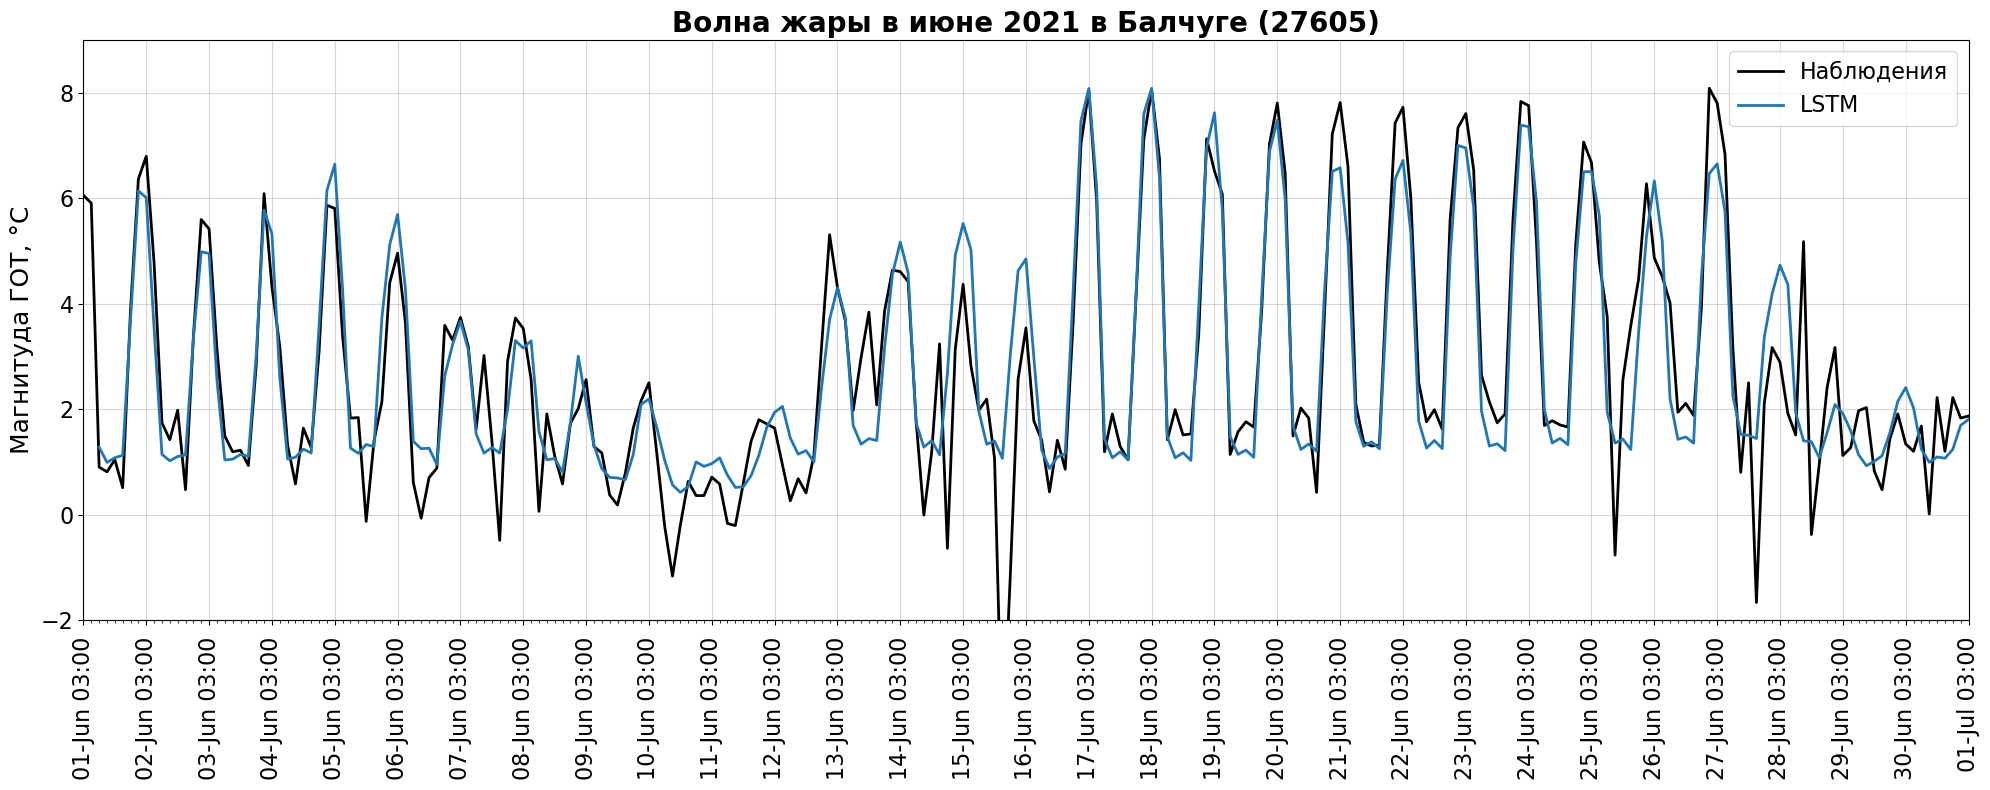

In [133]:
from matplotlib.dates import DateFormatter, DayLocator, HourLocator

# Построение графика
plt.figure(figsize=(20 ,8))

plt.plot(df_june2021.index, df_june2021['Observations'], label='Наблюдения', linewidth=2, color='black')
plt.plot(df_june2021.index, df_june2021['LSTM'], label='LSTM', linewidth=2)

# Настройка оси Ох
plt.gca().xaxis.set_major_locator(HourLocator(interval=24)) # интервал 24 часа
plt.gca().xaxis.set_minor_locator(HourLocator(interval=3)) # интервал 3 часа

plt.gca().xaxis.set_major_formatter(DateFormatter("%d-%b %H:%M ")) # формат 05-June 12:00

# Настройка графика
plt.title('Волна жары в июне 2021 в Балчуге (27605)', fontsize=20, fontweight='bold')
plt.ylabel('Магнитуда ГОТ, °C', fontsize=18, labelpad=5)

plt.legend(fontsize=16)

plt.grid(True, alpha=0.5)

# Устанавливаем одну шкалу на оcи Oy
plt.ylim(-2, 9)

# Устанавливаем пределы шкалы на оcи Oх
plt.xlim(df_june2021.index[0], df_june2021.index[-1])

# Увеличение размера подписей
plt.xticks(fontsize=16, rotation=90, ha='center')
plt.yticks(fontsize=16)
           
# Форматирование дат на оси Ох
plt.tight_layout()

# Сохраняем картинку
#plt.savefig('../Heat_wave_June_2021_Balchug_ru')

plt.show()

# КРОСС-ВАЛИДАЦИЯ

# ГРУЗИМ ДАННЫЕ

In [21]:
# Загрузка данных
data = pd.read_csv('D:/RSHU_LIMA_VARENTSOV_2025/data/Moscow_basic.csv', sep=';')
data = data.drop(['time', 'delta_t2m_id27416', 'delta_t2m_id27612', 'delta_t2m_id27617'], axis=1)

columns_to_drop = [col for col in data.columns if col.startswith('rur')]     # оставляем данные реанализа
data = data.drop(columns_to_drop, axis=1)
data = data.dropna()      # удаляем пропуски 

# Выделение целевой переменной и признаков
features = data.columns.drop('delta_t2m_id27605')
target = 'delta_t2m_id27605'

print(data.columns)

Index(['delta_t2m_id27605', 'ERA5_t2m', 'ERA5_ps', 'ERA5_u10m', 'ERA5_v10m',
       'ERA5_tcc', 'ERA5_lcc', 'ERA5_blh', 'ERA5_str', 'ERA5_ssr', 'ERA5_ssrd',
       'ERA5_strd', 'ERA5_vel10m', 'ERA5_dir10', 'ERA5_tp_3h', 'ERA5_rh2m'],
      dtype='object')


In [27]:
# Создание 5 больших блоков
N_SPLITS = 5
BLOCK_SIZE = len(data) // N_SPLITS  # Размер каждого блока

print(f"Всего данных: {len(data)}")
print(f"Размер блока: {BLOCK_SIZE}")
print(f"Количество блоков: {N_SPLITS}")

# Формирование 5 блоков
all_blocks_data = []
all_blocks_indices = []

for block_idx in range(N_SPLITS):
    start_idx = block_idx * BLOCK_SIZE
    # Для последнего блока берем все оставшиеся данные
    end_idx = (block_idx + 1) * BLOCK_SIZE if block_idx < N_SPLITS - 1 else len(data)
    
    block_data = data.iloc[start_idx:end_idx]
    X_block = block_data[features].values.astype(np.float32)
    y_block = block_data[target].values.astype(np.float32)
    
    # ИЗМЕНЕНИЕ: Создание последовательностей для предсказания текущего момента
    block_sequences = []
    block_targets = []
    block_seq_indices = []
    
    # Начинаем с SEQ_LENGTH - 1, чтобы иметь достаточно истории для первой последовательности
    for i in range(SEQ_LENGTH - 1, len(block_data)):
        # Признаки: моменты от i-SEQ_LENGTH+1 до i (SEQ_LENGTH последовательных моментов)
        block_sequences.append(X_block[i-SEQ_LENGTH+1:i+1])
        # Целевая переменная: момент i (текущий момент)
        block_targets.append(y_block[i])
        block_seq_indices.append(start_idx + i)
    
    all_blocks_data.append({
        'X': np.array(block_sequences),
        'y': np.array(block_targets),
        'indices': np.array(block_seq_indices),
        'block_id': block_idx
    })

# Определение модели LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size=len(features), hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.regressor = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.regressor(out[:, -1, :]).squeeze()

# Создаем массивы для всех блоков
all_X = np.concatenate([block['X'] for block in all_blocks_data])
all_y = np.concatenate([block['y'] for block in all_blocks_data])
all_groups = np.concatenate([[block['block_id']] * len(block['X']) for block in all_blocks_data])
all_indices = np.concatenate([block['indices'] for block in all_blocks_data])

# Массив для хранения всех прогнозов
full_predictions = np.full(len(data), np.nan)
fold_metrics = []
input_size = all_X.shape[2]

print(f"Всего блоков: {N_SPLITS}")
print(f"Всего последовательностей: {len(all_X)}")
print(f"Размерность признаков: {input_size}")

# Настоящая 5-кратная кросс-валидация по 5 блокам
group_kfold = GroupKFold(n_splits=N_SPLITS)

for fold, (train_idx, val_idx) in enumerate(group_kfold.split(all_X, all_y, all_groups)):
    train_blocks = np.unique(all_groups[train_idx])
    val_blocks = np.unique(all_groups[val_idx])
    
    print(f"\nFold {fold + 1}/{N_SPLITS}")
    print(f"Тренировочные блоки: {train_blocks} (блоки {list(train_blocks)})")
    print(f"Тестовые блоки: {val_blocks} (блок {list(val_blocks)})")
    
    # Нормализация данных для текущего фолда
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    # Обучение нормализаторов только на тренировочных данных
    X_train_fold_scaled = scaler_X.fit_transform(all_X[train_idx].reshape(-1, input_size)).reshape(all_X[train_idx].shape)
    y_train_fold_scaled = scaler_y.fit_transform(all_y[train_idx].reshape(-1, 1)).flatten()
    
    # Преобразование тестовых данных
    X_test_fold_scaled = scaler_X.transform(all_X[val_idx].reshape(-1, input_size)).reshape(all_X[val_idx].shape)
    y_test_fold_scaled = scaler_y.transform(all_y[val_idx].reshape(-1, 1)).flatten()
    
    # Создание DataLoader
    train_loader = DataLoader(
        TensorDataset(torch.tensor(X_train_fold_scaled), torch.tensor(y_train_fold_scaled)),
        batch_size=BATCH_SIZE,
        shuffle=True
    )
    
    # Обучение модели
    model = LSTMModel(input_size=input_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    print("Обучение модели...")
    for epoch in range(NUM_EPOCHS):
        model.train()
        total_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = torch.sqrt(nn.MSELoss()(outputs, batch_y))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{NUM_EPOCHS} | Loss: {total_loss / len(train_loader):.4f}')
    
    # Тестирование
    model.eval()
    with torch.no_grad():
        test_preds_scaled = model(torch.tensor(X_test_fold_scaled)).numpy()
    
    # Обратное преобразование прогнозов
    test_preds = scaler_y.inverse_transform(test_preds_scaled.reshape(-1, 1))
    y_test_true = scaler_y.inverse_transform(y_test_fold_scaled.reshape(-1, 1))
    
    # Сохраняем прогнозы для тестовой выборки
    test_indices = all_indices[val_idx]
    for idx, pred in zip(test_indices, test_preds.flatten()):
        full_predictions[idx] = pred
    
    # Расчет метрик
    rmse = np.sqrt(mean_squared_error(y_test_true, test_preds))
    r2 = r2_score(y_test_true, test_preds)
    fold_metrics.append({'fold': fold + 1, 'rmse': rmse, 'r2': r2})
    
    print(f"Fold {fold + 1} - RMSE: {rmse:.4f}, R²: {r2:.4f}")

# Сбор метрик кросс-валидации
cv_scores = {
    'test_r2': [m['r2'] for m in fold_metrics],
    'test_rmse': [m['rmse'] for m in fold_metrics]
}

# Вывод результатов кросс-валидации
print("\n" + "="*50)
print("Cross-Validation Results:")
print(f"R²: {np.mean(cv_scores['test_r2']):.4f} ± {np.std(cv_scores['test_r2']):.4f}")
print(f"RMSE: {np.mean(cv_scores['test_rmse']):.4f} ± {np.std(cv_scores['test_rmse']):.4f}")
print("="*50)

# Дополнительная статистика по фолдам
print("\nДетали по фолдам:")
for metric in fold_metrics:
    print(f"Fold {metric['fold']}: R² = {metric['r2']:.4f}, RMSE = {metric['rmse']:.4f}")

# Подсчет покрытия прогнозами
coverage = np.sum(~np.isnan(full_predictions)) / len(full_predictions) * 100
print(f"\nПокрытие данных: {coverage:.2f}%")

Всего данных: 34068
Размер блока: 6813
Количество блоков: 5
Всего блоков: 5
Всего последовательностей: 34058
Размерность признаков: 15

Fold 1/5
Тренировочные блоки: [0 1 2 3] (блоки [0, 1, 2, 3])
Тестовые блоки: [4] (блок [4])
Обучение модели...
Fold 1 - RMSE: 0.8504, R²: 0.7857

Fold 2/5
Тренировочные блоки: [0 1 2 4] (блоки [0, 1, 2, 4])
Тестовые блоки: [3] (блок [3])
Обучение модели...
Fold 2 - RMSE: 0.8039, R²: 0.7444

Fold 3/5
Тренировочные блоки: [0 1 3 4] (блоки [0, 1, 3, 4])
Тестовые блоки: [2] (блок [2])
Обучение модели...
Fold 3 - RMSE: 0.7877, R²: 0.7630

Fold 4/5
Тренировочные блоки: [0 2 3 4] (блоки [0, 2, 3, 4])
Тестовые блоки: [1] (блок [1])
Обучение модели...
Fold 4 - RMSE: 0.8527, R²: 0.7662

Fold 5/5
Тренировочные блоки: [1 2 3 4] (блоки [1, 2, 3, 4])
Тестовые блоки: [0] (блок [0])
Обучение модели...
Fold 5 - RMSE: 0.8923, R²: 0.7245

Cross-Validation Results:
R²: 0.7568 ± 0.0208
RMSE: 0.8374 ± 0.0374

Детали по фолдам:
Fold 1: R² = 0.7857, RMSE = 0.8504
Fold 2: R² =

In [53]:
len(full_predictions)

34068

In [57]:
len(data[target])

34068

# Облако точек

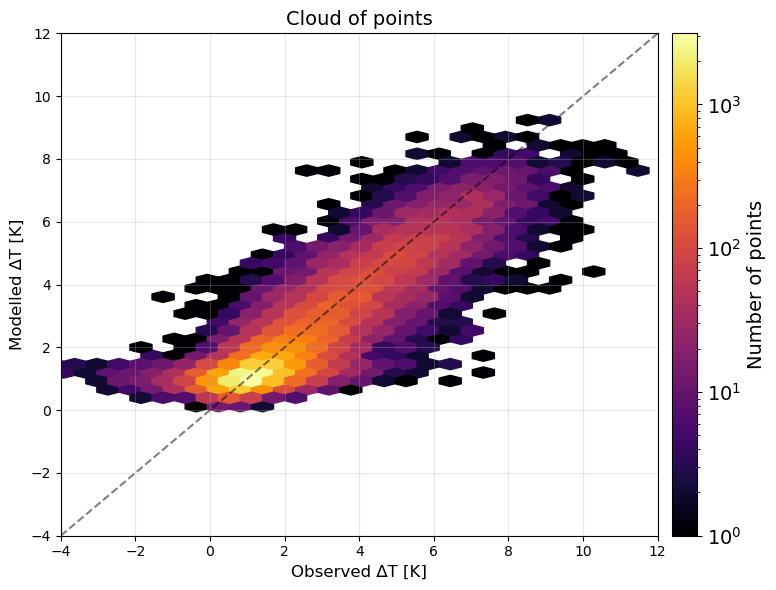

In [73]:
# Создаем фигуру с одним подграфиком
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Вручную задаем границы для осей (можно изменить по вашему усмотрению)
x_limits = [-4, 12]
y_limits = [-4, 12]

# Создаем hexbin plot, где цвет показывает количество точек в каждом шестиугольнике
hexbin = ax.hexbin(data[target], 
                   full_predictions, 
                   gridsize=30,  # количество шестиугольников по горизонтали
                   cmap='inferno',
                   mincnt=1,     # минимальное количество точек для отображения
                   bins='log' if len(full_predictions) > 100 else None)  # логарифмическая шкала если много точек

ax.set_xlabel('Observed ∆T [K]', fontsize=12)
ax.set_ylabel('Modelled ∆T [K]', fontsize=12)
ax.set_title('Cloud of points', fontsize=14)
ax.grid(alpha=0.3)

# Устанавливаем границы осей
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)

# Добавляем линию 1:1 для сравнения
lims = [min(x_limits[0], y_limits[0]), max(x_limits[1], y_limits[1])]
ax.plot(lims, lims, 'k--', alpha=0.5, label='1:1 line')

# Добавляем цветовую шкалу
cbar = fig.colorbar(hexbin, ax=ax, location='right', pad=0.02)
cbar.set_label('Number of points', fontsize=14)

# Увеличиваем размер шрифта делений на цветовой шкале
cbar.ax.tick_params(labelsize=14)

# Настраиваем общий вид
#plt.savefig('single_graph_of_points_cloud.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.tight_layout()
plt.show()